In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import fashion_mnist
import wandb

# Load the dataset
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
# Normalize images
train_images, test_images = train_images / 255.0, test_images / 255.0

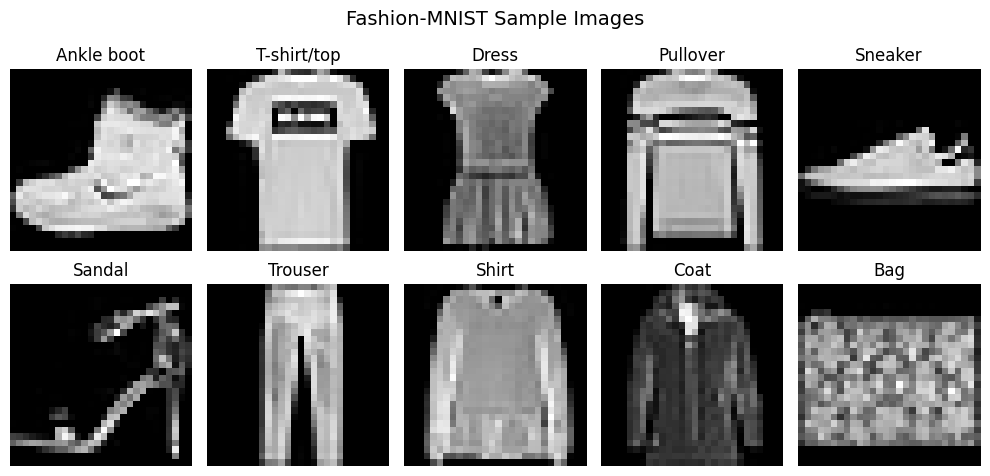

In [ ]:
# Define class names
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]
#intialize wanddb
wandb.init(project="deep_learning", name='mnist_dataset')
# Select one image per class
samples_per_class = {}
for img, label in zip(train_images, train_labels):
    if label not in samples_per_class:
        samples_per_class[label] = img
    if len(samples_per_class) == len(class_names):
        break
wandb.log({"Fashion-MNIST Sample Images": [wandb.Image(img, caption=class_names[label]) for label, img in samples_per_class.items()]})

# Plot images
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
fig.suptitle("Fashion-MNIST Sample Images", fontsize=14)

for ax, (label, image) in zip(axes.flat, samples_per_class.items()):
    ax.imshow(image, cmap='gray')
    ax.set_title(class_names[label])
    ax.axis('off')

plt.tight_layout()
plt.show()
wandb.finish()

In [ ]:
#flatten the images
train_images = train_images.reshape(train_images.shape[0], -1)
test_images = test_images.reshape(test_images.shape[0], -1)

In [ ]:
import numpy as np

# Helper Functions
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def softmax(z):
    exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))  # Subtract max for numerical stability
    return exp_z / np.sum(exp_z, axis=1, keepdims=True)

def relu(z):
    return np.maximum(0, z)

def relu_derivative(z):
    return (z > 0).astype(float)


def cross_entropy_loss(y_true, y_pred):
    n_samples = y_true.shape[0]
    logp = -np.log(y_pred[range(n_samples), y_true])
    return np.sum(logp) / n_samples

In [ ]:
import numpy as np

# Neural Network Class
class NeuralNetwork1:
    def __init__(self, layer_sizes, activation='relu', weight_init='xavier'):
        self.layer_sizes = layer_sizes
        self.num_layers = len(layer_sizes)
        self.activation = activation
        self.weight_init = weight_init
        self.weights = []
        self.biases = []
        for i in range(1, self.num_layers):
            fan_in = layer_sizes[i-1]
            fan_out = layer_sizes[i]
            if weight_init == 'xavier':
                weight = np.random.randn(fan_out, fan_in) * np.sqrt(2 / (fan_in + fan_out))
            else:  # random
                weight = np.random.randn(fan_out, fan_in) * 0.01
            bias = np.zeros(fan_out)
            self.weights.append(weight)
            self.biases.append(bias)
    def forward(self, X, training=False):
        a = X
        if training:
            self.activations = [a]
            self.zs = []
        for l in range(self.num_layers - 1):
            z = np.dot(a, self.weights[l].T) + self.biases[l]
            if training:
                self.zs.append(z)
            if l < self.num_layers - 2:
                if self.activation == 'relu':
                    a = relu(z)
                elif self.activation == 'sigmoid':
                    a = sigmoid(z)
                elif self.activation == 'tanh':
                    a = np.tanh(z)
            else:
                a = softmax(z)
            if training:
                self.activations.append(a)
        return a
    def predict(self, X):
        return self.forward(X, training=False)

# Example Usage
if __name__ == "__main__":
    # Create a network: 784 input -> 256 hidden -> 128 hidden -> 10 output
    nn = NeuralNetwork1([784, 256, 128, 10])
    # Simulate 1 input sample (e.g., Fashion-MNIST images)
    x = train_images[:1].reshape(1, 784)
    # Print probabilities for each class
    probs = nn.predict(x)
    # Print probabilities for each sample
    for i, prob in enumerate(probs):
        print(f"Sample {i+1} probabilities: {prob}")

Sample 1 probabilities: [0.07099812 0.0974364  0.01315515 0.21327577 0.01982128 0.06755199
 0.12833614 0.09968681 0.21423271 0.07550564]


In [ ]:

def to_one_hot(labels, num_classes=10):
    """Convert labels to one-hot encoding."""
    return np.eye(num_classes)[labels]

# Base Optimizer Class
class Optimizer:
    """Abstract base class for optimizers."""
    def update(self, weights, biases, grads_w, grads_b):
        raise NotImplementedError("Subclasses must implement this method.")

# SGD Optimizer with L2 Regularization
class SGD(Optimizer):
    def __init__(self, learning_rate=0.01, weight_decay=0.0005):  # Added weight_decay parameter
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay  # L2 regularization coefficient

    def update(self, weights, biases, grads_w, grads_b):
        for i in range(len(weights)):
            # Apply L2 Regularization: weight decay term added to gradient
            weights[i] -= self.learning_rate * (grads_w[i] + self.weight_decay * weights[i])

            # Biases are NOT regularized (to avoid unnecessary penalty)
            biases[i] -= self.learning_rate * grads_b[i]




In [ ]:
# Momentum Optimizer with L2 Regularization
class Momentum(Optimizer):
    def __init__(self, learning_rate=0.01, momentum=0.9, weight_decay=0.0005):
        self.learning_rate = learning_rate
        self.momentum = momentum
        self.weight_decay = weight_decay  # L2 regularization coefficient
        self.velocity_w = None
        self.velocity_b = None

    def update(self, weights, biases, grads_w, grads_b):
        if self.velocity_w is None:
            self.velocity_w = [np.zeros_like(w) for w in weights]
            self.velocity_b = [np.zeros_like(b) for b in biases]

        for i in range(len(weights)):
            # Apply L2 Regularization: Add weight decay term to gradients
            grads_w[i] += self.weight_decay * weights[i]

            # Update velocity
            self.velocity_w[i] = self.momentum * self.velocity_w[i] + self.learning_rate * grads_w[i]
            self.velocity_b[i] = self.momentum * self.velocity_b[i] + self.learning_rate * grads_b[i]

            # Update weights and biases
            weights[i] -= self.velocity_w[i]
            biases[i] -= self.velocity_b[i]


In [ ]:
# Nesterov Optimizer with L2 Regularization
class Nesterov(Optimizer):
    def __init__(self, learning_rate=0.01, momentum=0.9, weight_decay=0.0005):
        self.learning_rate = learning_rate
        self.momentum = momentum
        self.weight_decay = weight_decay  # L2 regularization coefficient
        self.velocity_w = None
        self.velocity_b = None

    def update(self, weights, biases, grads_w, grads_b):
        if self.velocity_w is None:
            self.velocity_w = [np.zeros_like(w) for w in weights]
            self.velocity_b = [np.zeros_like(b) for b in biases]

        for i in range(len(weights)):
            # Look ahead step: Compute future weights (before updating gradients)
            look_ahead_w = weights[i] - self.momentum * self.velocity_w[i]
            look_ahead_b = biases[i] - self.momentum * self.velocity_b[i]

            # Apply L2 Regularization: Add weight decay term to gradients
            grads_w[i] += self.weight_decay * look_ahead_w

            # Compute velocity updates
            self.velocity_w[i] = self.momentum * self.velocity_w[i] + self.learning_rate * grads_w[i]
            self.velocity_b[i] = self.momentum * self.velocity_b[i] + self.learning_rate * grads_b[i]

            # Update weights and biases
            weights[i] -= self.velocity_w[i]
            biases[i] -= self.velocity_b[i]


In [ ]:
# RMSProp Optimizer with L2 Regularization
class RMSProp(Optimizer):
    def __init__(self, learning_rate=0.001, beta=0.9, epsilon=1e-8, weight_decay=0.0005):
        self.learning_rate = learning_rate
        self.beta = beta
        self.epsilon = epsilon
        self.weight_decay = weight_decay  # L2 regularization coefficient
        self.s_w = None
        self.s_b = None

    def update(self, weights, biases, grads_w, grads_b):
        if self.s_w is None:
            self.s_w = [np.zeros_like(w) for w in weights]
            self.s_b = [np.zeros_like(b) for b in biases]

        for i in range(len(weights)):
            # Apply L2 Regularization: Add weight decay term to gradients
            grads_w[i] += self.weight_decay * weights[i]

            # Compute moving average of squared gradients
            self.s_w[i] = self.beta * self.s_w[i] + (1 - self.beta) * (grads_w[i] ** 2)
            self.s_b[i] = self.beta * self.s_b[i] + (1 - self.beta) * (grads_b[i] ** 2)

            # Update weights and biases using RMSProp rule
            weights[i] -= self.learning_rate * grads_w[i] / (np.sqrt(self.s_w[i]) + self.epsilon)
            biases[i] -= self.learning_rate * grads_b[i] / (np.sqrt(self.s_b[i]) + self.epsilon)



In [ ]:
# Adam Optimizer with L2 Regularization
class Adam(Optimizer):
    def __init__(self, learning_rate=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8, weight_decay=0.0005):
        self.learning_rate = learning_rate
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.weight_decay = weight_decay  # L2 regularization coefficient
        self.m_w = None
        self.m_b = None
        self.v_w = None
        self.v_b = None
        self.t = 0

    def update(self, weights, biases, grads_w, grads_b):
        if self.m_w is None:
            self.m_w = [np.zeros_like(w) for w in weights]
            self.m_b = [np.zeros_like(b) for b in biases]
            self.v_w = [np.zeros_like(w) for w in weights]
            self.v_b = [np.zeros_like(b) for b in biases]

        self.t += 1
        for i in range(len(weights)):
            # Apply L2 Regularization (Weight Decay)
            grads_w[i] += self.weight_decay * weights[i]

            # Compute first moment estimate (moving average of gradients)
            self.m_w[i] = self.beta1 * self.m_w[i] + (1 - self.beta1) * grads_w[i]
            self.m_b[i] = self.beta1 * self.m_b[i] + (1 - self.beta1) * grads_b[i]

            # Compute second moment estimate (moving average of squared gradients)
            self.v_w[i] = self.beta2 * self.v_w[i] + (1 - self.beta2) * (grads_w[i] ** 2)
            self.v_b[i] = self.beta2 * self.v_b[i] + (1 - self.beta2) * (grads_b[i] ** 2)

            # Bias correction
            m_w_hat = self.m_w[i] / (1 - self.beta1 ** self.t)
            m_b_hat = self.m_b[i] / (1 - self.beta1 ** self.t)
            v_w_hat = self.v_w[i] / (1 - self.beta2 ** self.t)
            v_b_hat = self.v_b[i] / (1 - self.beta2 ** self.t)

            # Update weights and biases
            weights[i] -= self.learning_rate * m_w_hat / (np.sqrt(v_w_hat) + self.epsilon)
            biases[i] -= self.learning_rate * m_b_hat / (np.sqrt(v_b_hat) + self.epsilon)


In [ ]:
# Nadam Optimizer with L2 Regularization
class Nadam(Optimizer):
    def __init__(self, learning_rate=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8, weight_decay=0.0005):
        self.learning_rate = learning_rate
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.weight_decay = weight_decay  # L2 Regularization (Weight Decay)
        self.m_w = None
        self.m_b = None
        self.v_w = None
        self.v_b = None
        self.t = 0

    def update(self, weights, biases, grads_w, grads_b):
        if self.m_w is None:
            self.m_w = [np.zeros_like(w) for w in weights]
            self.m_b = [np.zeros_like(b) for b in biases]
            self.v_w = [np.zeros_like(w) for w in weights]
            self.v_b = [np.zeros_like(b) for b in biases]

        self.t += 1
        for i in range(len(weights)):
            # Apply L2 Regularization (Weight Decay)
            grads_w[i] += self.weight_decay * weights[i]

            # Compute first moment estimate (moving avg of gradients)
            self.m_w[i] = self.beta1 * self.m_w[i] + (1 - self.beta1) * grads_w[i]
            self.m_b[i] = self.beta1 * self.m_b[i] + (1 - self.beta1) * grads_b[i]

            # Compute second moment estimate (moving avg of squared gradients)
            self.v_w[i] = self.beta2 * self.v_w[i] + (1 - self.beta2) * (grads_w[i] ** 2)
            self.v_b[i] = self.beta2 * self.v_b[i] + (1 - self.beta2) * (grads_b[i] ** 2)

            # Bias correction
            m_w_hat = self.m_w[i] / (1 - self.beta1 ** self.t)
            m_b_hat = self.m_b[i] / (1 - self.beta1 ** self.t)
            v_w_hat = self.v_w[i] / (1 - self.beta2 ** self.t)
            v_b_hat = self.v_b[i] / (1 - self.beta2 ** self.t)

            # Nesterov-style momentum update
            m_w_nesterov = self.beta1 * m_w_hat + (1 - self.beta1) * grads_w[i] / (1 - self.beta1 ** self.t)
            m_b_nesterov = self.beta1 * m_b_hat + (1 - self.beta1) * grads_b[i] / (1 - self.beta1 ** self.t)

            # Update weights and biases
            weights[i] -= self.learning_rate * m_w_nesterov / (np.sqrt(v_w_hat) + self.epsilon)
            biases[i] -= self.learning_rate * m_b_nesterov / (np.sqrt(v_b_hat) + self.epsilon)


In [ ]:
import numpy as np
import wandb
from sklearn.model_selection import train_test_split

def cross_entropy_loss(y_true, y_pred):
    epsilon = 1e-15
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
    return -np.sum(y_true * np.log(y_pred)) / y_true.shape[0]


# Neural Network class
class NeuralNetwork(NeuralNetwork1):

    def backward(self, y, weight_decay=0):
        batch_size = y.shape[0]
        grads_w = []
        grads_b = []
        dz = self.activations[-1] - y
        for l in range(self.num_layers - 2, -1, -1):
            a_prev = self.activations[l]
            dW = np.dot(dz.T, a_prev) / batch_size + weight_decay * self.weights[l]
            db = np.sum(dz, axis=0) / batch_size
            grads_w.insert(0, dW)
            grads_b.insert(0, db)
            if l > 0:
                z = self.zs[l-1]
                if self.activation == 'relu':
                    sigma_prime = (z > 0).astype(float)
                elif self.activation == 'sigmoid':
                    a = sigmoid(z)
                    sigma_prime = a * (1 - a)
                elif self.activation == 'tanh':
                    a = np.tanh(z)
                    sigma_prime = 1 - a**2
                dz = np.dot(dz, self.weights[l]) * sigma_prime
        return grads_w, grads_b

    def train(self, X_train, y_train, X_val, y_val, epochs, batch_size, optimizer, weight_decay=0):
        num_samples = X_train.shape[0]
        y_train_onehot = to_one_hot(y_train, 10)
        y_val_onehot = to_one_hot(y_val, 10)

        for epoch in range(epochs):
            # Training phase
            train_loss = 0
            indices = np.random.permutation(num_samples)
            X_shuffled = X_train[indices]
            y_shuffled = y_train_onehot[indices]
            for i in range(0, num_samples, batch_size):
                X_batch = X_shuffled[i:i + batch_size]
                y_batch = y_shuffled[i:i + batch_size]
                y_pred_batch = self.forward(X_batch, training=True)
                train_loss += cross_entropy_loss(y_batch, y_pred_batch) * X_batch.shape[0]
                grads_w, grads_b = self.backward(y_batch, weight_decay)
                optimizer.update(self.weights, self.biases, grads_w, grads_b)
            train_loss /= num_samples  # Average training loss per sample

            # Compute training accuracy
            train_acc = self.compute_accuracy(X_train, y_train)

            # Validation phase
            y_pred_val = self.forward(X_val, training=False)
            val_loss = cross_entropy_loss(y_val_onehot, y_pred_val)
            val_acc = self.compute_accuracy(X_val, y_val)
            # wandb.init(project="deep_learning",name='test_accuracy')
            #Log metrics to Wandb
            wandb.log({
                'epoch': epoch + 1,
                'train_loss': train_loss,
                'train_accuracy': train_acc,
                'val_loss': val_loss,
                'val_accuracy': val_acc
            })
        wandb.finish()

        return  val_acc, val_loss

    def compute_accuracy(self, X, y):
        predictions = np.argmax(self.forward(X, training=False), axis=1)
        return np.mean(predictions == y)

# x_train = train_images.reshape(train_images.shape[0], -1) / 255.0
# x_test = test_images.reshape(test_images.shape[0], -1) / 255.0
# # Train the network
# nn = NeuralNetwork([784, 128, 10], 'sigmoid', 'random')
# optimizer = Nadam(learning_rate=0.001)

# nn.train(x_train, train_labels, x_test, test_labels, epochs=1, batch_size=16, optimizer=optimizer)

# # Compute test accuracy
# accuracy = nn.compute_accuracy(x_test, test_labels)
# print(f"Test Accuracy: {accuracy:.4f}")


In [ ]:
# Wandb sweap configuration
sweep_config = {
    'method': 'bayes',
    'metric': {'name': 'val_accuracy', 'goal': 'maximize'},
    'parameters': {
        'epochs': {'values': [5, 10]},
        'num_hidden_layers': {'values': [3, 4, 5]},
        'hidden_size': {'values': [32, 64, 128]},
        'weight_decay': {'values': [0, 0.0005, 0.5]},
        'learning_rate': {'values': [1e-3, 1e-4]},
        'optimizer': {'values': ['sgd', 'momentum', 'adam','nadam', 'rmsprop','nesterov' ]},
        'batch_size': {'values': [16, 32, 64]},
        'weight_init': {'values': ['random', 'xavier']},
        'activation': {'values': ['sigmoid', 'tanh', 'relu']}
    }
}

# Training function for Wandb sweep
def train():
    config_defaults = {
        'epochs': 5,
        'num_hidden_layers': 3,
        'hidden_size': 32,
        'weight_decay': 0,
        'learning_rate': 1e-3,
        'optimizer': 'adam',
        'batch_size': 32,
        'weight_init': 'xavier',
        'activation': 'relu'
    }
    # Initialize Wandb run
    run_name = f"hl_{config_defaults['num_hidden_layers']}_bs_{config_defaults['batch_size']}_ac_{config_defaults['activation']}"
    wandb.init(config=config_defaults, name=run_name)
    config = wandb.config


    X_train, X_val, y_train, y_val = train_test_split(train_images, train_labels, test_size=0.1, random_state=42)

    # Define network architecture
    layer_sizes = [784] + [config.hidden_size] * config.num_hidden_layers + [10]
    nn = NeuralNetwork(layer_sizes, activation=config.activation, weight_init=config.weight_init)

    # Select optimizer
    if config.optimizer == 'sgd':
        optimizer = SGD(learning_rate=config.learning_rate)
    elif config.optimizer == 'momentum':
        optimizer = Momentum(learning_rate=config.learning_rate)
    elif config.optimizer == 'adam':
        optimizer = Adam(learning_rate=config.learning_rate)
    elif config.optimizer == 'nadam':
        optimizer = Nadam(learning_rate=config.learning_rate)
    elif config.optimizer == 'rmsprop':
        optimizer = RMSProp(learning_rate=config.learning_rate)
    elif config.optimizer == 'nesterov':
        optimizer = Nesterov(learning_rate=config.learning_rate)

    # Train the model
    val_acc, val_loss = nn.train(X_train, y_train, X_val, y_val, config.epochs, config.batch_size, optimizer, config.weight_decay)

    # wandb.finish()

# Initialize and run the sweep
sweep_id = wandb.sweep(sweep_config, project="deep_learning")
wandb.agent(sweep_id, function=train, count=1)
# wandb.finish()

Create sweep with ID: qnfgy5l5
Sweep URL: https://wandb.ai/ma24m004-iit-madras/deep_learning/sweeps/qnfgy5l5


wandb: Agent Starting Run: 9jkgc746 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,██▁█████▄█
train_loss,█▂▁▁▁▁▁▂▁▁
val_accuracy,▁▁█▁▁▁▁▁▅▁
val_loss,█▇▁▄▆▇▅▄▁▄
epoch,10
train_accuracy,0.10093
train_loss,2.30266
val_accuracy,0.09167
val_loss,2.30272


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(train_images, train_labels, test_size=0.1, random_state=42)
#flatten the images
X_train = X_train.reshape(X_train.shape[0], -1) / 255.0
X_val = X_val.reshape(X_val.shape[0], -1) / 255.0
test_images = test_images.reshape(test_images.shape[0], -1) / 255.0

epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▆▆▇▇▇███
train_loss,█▃▂▂▂▁▁▁▁▁
val_accuracy,▁▄▅▆▇▇▇▇██
val_loss,█▅▄▃▂▂▂▂▁▁
epoch,10
train_accuracy,0.75463
train_loss,0.66171
val_accuracy,0.75667
val_loss,0.65345


Confusion Matrix:
[[779   3  33  94  37   0  41   0  13   0]
 [ 20 916   8  47   5   0   3   0   1   0]
 [ 35   0 687  12 191   0  66   0   9   0]
 [ 70  13   6 818  51   5  30   0   7   0]
 [  8   0 168  52 701   1  52   0  18   0]
 [  0   0   0   8   0 875   0  66  10  41]
 [200   0 156  63 458   1  99   0  23   0]
 [  0   0   0   0   0  65   0 887   0  48]
 [  0   0   9  14  60  51   5   3 855   3]
 [  0   0   0   0   0  62   0  72   6 860]]


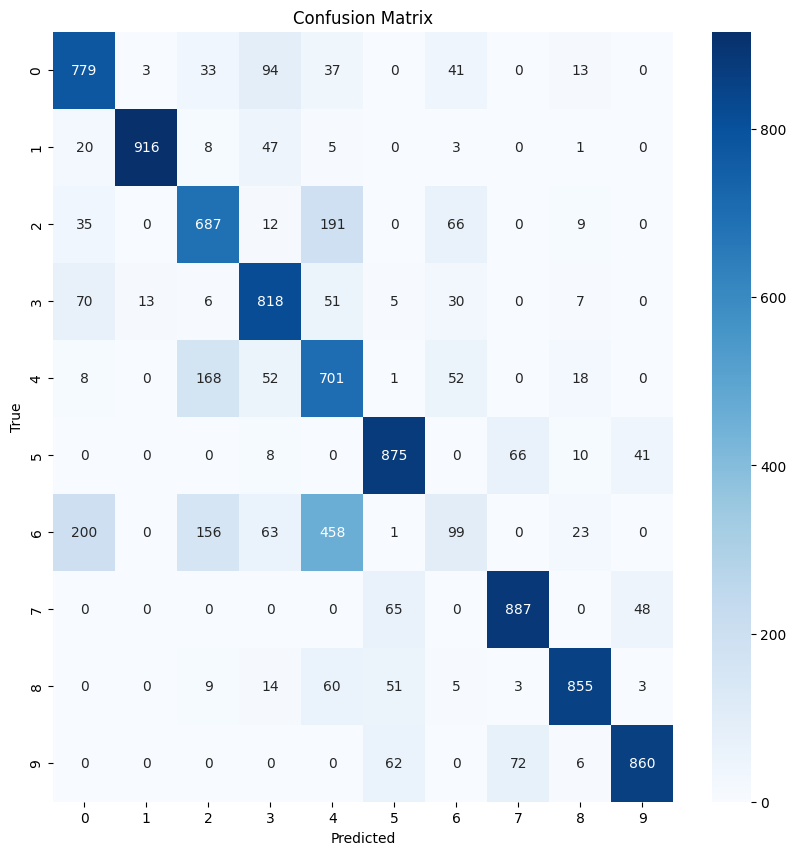

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import wandb
wandb.init(project="deep_learning", name='confusion_matrix')
# Assuming best_config from sweep (update with actual best after sweep)
best_config = {
    'epochs': 10, 'num_hidden_layers': 4, 'hidden_size': 128, 'weight_decay': 0,
    'learning_rate': 1e-4, 'optimizer': 'adam', 'batch_size': 16,
    'initialization': 'xavier', 'activation': 'relu'
}

layer_sizes = [784] + [best_config['hidden_size']] * best_config['num_hidden_layers'] + [10]
model = NeuralNetwork(layer_sizes, best_config['activation'], best_config['initialization'])
optimizer = Adam(best_config['learning_rate'])

model.train(X_train,y_train, X_val, y_val, best_config['epochs'], best_config['batch_size'], optimizer, best_config['weight_decay'])

# Generate predictions
y_pred_val = model.predict(test_images)
y_pred_val_classes = np.argmax(y_pred_val, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(test_labels, y_pred_val_classes)

# Optional: Print the confusion matrix
print("Confusion Matrix:")
print(cm)

# Visualize the confusion matrix
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

wandb.init(project="deep_learning", name='confusion_matrix')
# Log the confusion matrix plot to wandb
wandb.log({"confusion_matrix": wandb.Image(plt.gcf())})

# Show the plot (optional)
plt.show()

# Finish the wandb run
wandb.finish()

In [ ]:
# Squared error loss
def squared_error_loss(y_true, y_pred):
    return np.mean(np.square(y_true - y_pred))

In [ ]:
import numpy as np
import wandb
from sklearn.model_selection import train_test_split


# Neural Network class
class NeuralNetwork(NeuralNetwork1):

    def backward(self, y, weight_decay=0):
        batch_size = y.shape[0]
        grads_w = []
        grads_b = []
        v = 2 * (self.activations[-1] - y) / batch_size

        dz = self.activations[-1] * v - self.activations[-1] * np.sum(self.activations[-1] * v, axis=1, keepdims=True)
        for l in range(self.num_layers - 2, -1, -1):
            a_prev = self.activations[l]
            dW = np.dot(dz.T, a_prev) / batch_size + weight_decay * self.weights[l]
            db = np.sum(dz, axis=0) / batch_size
            grads_w.insert(0, dW)
            grads_b.insert(0, db)
            if l > 0:
                z = self.zs[l-1]
                if self.activation == 'relu':
                    sigma_prime = (z > 0).astype(float)
                elif self.activation == 'sigmoid':
                    a = sigmoid(z)
                    sigma_prime = a * (1 - a)
                elif self.activation == 'tanh':
                    a = np.tanh(z)
                    sigma_prime = 1 - a**2
                dz = np.dot(dz, self.weights[l]) * sigma_prime
        return grads_w, grads_b

    def train(self, X_train, y_train, X_val, y_val, epochs, batch_size, optimizer, weight_decay=0):
        num_samples = X_train.shape[0]
        y_train_onehot = to_one_hot(y_train, 10)
        y_val_onehot = to_one_hot(y_val, 10)

        for epoch in range(epochs):
            # Training phase
            train_loss = 0
            indices = np.random.permutation(num_samples)
            X_shuffled = X_train[indices]
            y_shuffled = y_train_onehot[indices]
            for i in range(0, num_samples, batch_size):
                X_batch = X_shuffled[i:i + batch_size]
                y_batch = y_shuffled[i:i + batch_size]
                y_pred_batch = self.forward(X_batch, training=True)
                train_loss += squared_error_loss(y_batch, y_pred_batch) * X_batch.shape[0]
                grads_w, grads_b = self.backward(y_batch, weight_decay)
                optimizer.update(self.weights, self.biases, grads_w, grads_b)
            train_loss /= num_samples  # Average training loss per sample

            # Compute training accuracy
            train_acc = self.compute_accuracy(X_train, y_train)

            # Validation phase
            y_pred_val = self.forward(X_val, training=False)
            val_loss = squared_error_loss(y_val_onehot, y_pred_val)
            val_acc = self.compute_accuracy(X_val, y_val)
            # wandb.init(project="deep_learning",name='test_accuracy')
            #Log metrics to Wandb
            wandb.log({
                'epoch': epoch + 1,
                'train_loss': train_loss,
                'train_accuracy': train_acc,
                'val_loss': val_loss,
                'val_accuracy': val_acc
            })
        wandb.finish()

        return  val_acc, val_loss

        # # Final metrics after training
        # final_train_loss = squared_error_loss(y_train_onehot, self.forward(X_train, training=False))
        # final_val_loss = val_loss
        # final_val_acc = val_acc
        # wandb.log({
        #     'final_train_loss': final_train_loss,
        #     'final_val_loss': final_val_loss,
        #     'final_val_accuracy': final_val_acc
        # })

        # return final_val_acc, final_val_loss

    def compute_accuracy(self, X, y):
        predictions = np.argmax(self.forward(X, training=False), axis=1)
        return np.mean(predictions == y)

# x_train = train_images.reshape(train_images.shape[0], -1) / 255.0
# x_test = test_images.reshape(test_images.shape[0], -1) / 255.0
# # Train the network
# nn = NeuralNetwork([784, 128, 10], 'sigmoid', 'random')
# optimizer = Nadam(learning_rate=0.001)

# nn.train(x_train, train_labels, x_test, test_labels, epochs=1, batch_size=16, optimizer=optimizer)

# # Compute test accuracy
# accuracy = nn.compute_accuracy(x_test, test_labels)
# print(f"Test Accuracy: {accuracy:.4f}")


In [ ]:
# Wandb sweap configuration
sweep_config = {
    'method': 'bayes',
    'metric': {'name': 'val_accuracy', 'goal': 'maximize'},
    'parameters': {
        'epochs': {'values': [5, 10]},
        'num_hidden_layers': {'values': [3, 4, 5]},
        'hidden_size': {'values': [32, 64, 128]},
        'weight_decay': {'values': [0, 0.0005, 0.5]},
        'learning_rate': {'values': [1e-3, 1e-4]},
        'optimizer': {'values': ['sgd', 'momentum', 'adam','nadam', 'rmsprop','nesterov' ]},
        'batch_size': {'values': [16, 32, 64]},
        'weight_init': {'values': ['random', 'xavier']},
        'activation': {'values': ['sigmoid', 'tanh', 'relu']}
    }
}

# Training function for Wandb sweep
def train():
    config_defaults = {
        'epochs': 5,
        'num_hidden_layers': 3,
        'hidden_size': 32,
        'weight_decay': 0,
        'learning_rate': 1e-3,
        'optimizer': 'adam',
        'batch_size': 32,
        'weight_init': 'xavier',
        'activation': 'relu'
    }
    # Initialize Wandb run
    run_name = f"hl_{config_defaults['num_hidden_layers']}_bs_{config_defaults['batch_size']}_ac_{config_defaults['activation']}"
    wandb.init(config=config_defaults, name=run_name)
    config = wandb.config


    X_train, X_val, y_train, y_val = train_test_split(train_images, train_labels, test_size=0.1, random_state=42)

    # Define network architecture
    layer_sizes = [784] + [config.hidden_size] * config.num_hidden_layers + [10]
    nn = NeuralNetwork(layer_sizes, activation=config.activation, weight_init=config.weight_init)

    # Select optimizer
    if config.optimizer == 'sgd':
        optimizer = SGD(learning_rate=config.learning_rate)
    elif config.optimizer == 'momentum':
        optimizer = Momentum(learning_rate=config.learning_rate)
    elif config.optimizer == 'adam':
        optimizer = Adam(learning_rate=config.learning_rate)
    elif config.optimizer == 'nadam':
        optimizer = Nadam(learning_rate=config.learning_rate)
    elif config.optimizer == 'rmsprop':
        optimizer = RMSProp(learning_rate=config.learning_rate)
    elif config.optimizer == 'nesterov':
        optimizer = Nesterov(learning_rate=config.learning_rate)

    # Train the model
    val_acc, val_loss = nn.train(X_train, y_train, X_val, y_val, config.epochs, config.batch_size, optimizer, config.weight_decay)

    wandb.finish()

# Initialize and run the sweep
sweep_id = wandb.sweep(sweep_config, project="deep_learning1")
wandb.agent(sweep_id, function=train, count=50)
wandb.finish()

Create sweep with ID: 00l51nip
Sweep URL: https://wandb.ai/ma24m004-iit-madras/deep_learning1/sweeps/00l51nip


wandb: Agent Starting Run: 67zk2766 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


epoch,▁▃▅▆█
train_accuracy,▁▁▁▁▁
train_loss,█▆▄▂▁
val_accuracy,▁▁▁▁▁
val_loss,█▆▄▃▁
epoch,5
train_accuracy,0.09961
train_loss,0.09001
val_accuracy,0.1035
val_loss,0.09001


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: k2xcf00x with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


epoch,▁▃▅▆█
train_accuracy,▁▁▁▁▁
train_loss,▁▁▁▁▁
val_accuracy,▁▁▁▁▁
val_loss,▁▁▁▁▁
epoch,5
train_accuracy,0.10093
train_loss,0.09
val_accuracy,0.09167
val_loss,0.09


wandb: Agent Starting Run: wzzu4m2v with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0
wandb: 	weight_init: random


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▁▁▁▁▁▁▁▁▁
train_loss,█▇▆▆▅▄▃▃▂▁
val_accuracy,▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▆▆▅▄▃▃▂▁
epoch,10
train_accuracy,0.0995
train_loss,0.09001
val_accuracy,0.1045
val_loss,0.09001


wandb: Agent Starting Run: qk26wrfl with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0
wandb: 	weight_init: random


epoch,▁▃▅▆█
train_accuracy,▁▃▅▇█
train_loss,█▆▅▃▁
val_accuracy,▁▂▄▆█
val_loss,██▅▅▁
epoch,5
train_accuracy,0.15733
train_loss,0.09
val_accuracy,0.14817
val_loss,0.09


wandb: Agent Starting Run: 3ymuqtw8 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▁▁▂▂▂▃▄▆█
train_loss,██▇▆▅▅▄▃▂▁
val_accuracy,▁▁▂▃▃▄▅▅▆█
val_loss,█▇▇▅▅▄▄▂▂▁
epoch,10
train_accuracy,0.11926
train_loss,0.09
val_accuracy,0.115
val_loss,0.09


wandb: Agent Starting Run: itjbuaqk with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


epoch,▁▃▅▆█
train_accuracy,▁▃▄▅█
train_loss,█▆▄▂▁
val_accuracy,▁▂▄▅█
val_loss,█▆▄▂▁
epoch,5
train_accuracy,0.22502
train_loss,0.08857
val_accuracy,0.224
val_loss,0.08839


wandb: Agent Starting Run: iaez8il3 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▁▃▄▄▅▆▇██
train_loss,█▆▅▃▃▂▂▁▁▁
val_accuracy,▁▃▆▆▆▆▆▆██
val_loss,█▆▅▄▃▂▂▁▁▁
epoch,10
train_accuracy,0.07213
train_loss,0.09004
val_accuracy,0.06983
val_loss,0.09004


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: e6jboebc with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▂▄▆▅▅█▇▄▅
train_loss,█▆▄▃▂▂▁▁▁▃
val_accuracy,▁▂▄▆▅▆█▇▅▅
val_loss,█▅▅▄▃▃▁▁▁▅
epoch,10
train_accuracy,0.58093
train_loss,0.05805
val_accuracy,0.58417
val_loss,0.05885


wandb: Agent Starting Run: sh3o1rir with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▅▄██▄▂▅█▁▂
train_loss,▁█████████
val_accuracy,▄▅▁▁▅▇▄▁█▇
val_loss,▂▃▇▄▃██▄▁▂
epoch,10
train_accuracy,0.0998
train_loss,0.09
val_accuracy,0.10183
val_loss,0.09


wandb: Agent Starting Run: ecoag6z5 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▄▂▃████▁▄█
train_loss,▁█████████
val_accuracy,▅▇▆▁▁▁▁█▅▁
val_loss,█▄▂▅▃▇▄▅▁▃
epoch,10
train_accuracy,0.10093
train_loss,0.09
val_accuracy,0.09167
val_loss,0.09


wandb: Agent Starting Run: ytgj9w1b with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0
wandb: 	weight_init: random


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▁▁▁▁▁▁▁▁▁
train_loss,█▇▆▅▅▄▃▂▂▁
val_accuracy,▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▆▆▅▄▃▂▂▁
epoch,10
train_accuracy,0.10093
train_loss,0.09004
val_accuracy,0.09167
val_loss,0.09009


wandb: Agent Starting Run: he1gvi66 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


epoch,▁▃▅▆█
train_accuracy,▁▁▁▁▁
train_loss,█▆▄▃▁
val_accuracy,▁▁▁▁▁
val_loss,█▆▄▃▁
epoch,5
train_accuracy,0.0995
train_loss,0.09147
val_accuracy,0.1045
val_loss,0.09136


wandb: Agent Starting Run: we4mnrei with config:
wandb: 	activation: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.5
wandb: 	weight_init: xavier


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▄▆▇▇██▇▁
train_loss,█▅▃▂▂▁▁▁▁▁
val_accuracy,▁▃▅▆▆███▇▃
val_loss,█▅▃▂▂▁▁▁▁▁
epoch,10
train_accuracy,0.10781
train_loss,0.09001
val_accuracy,0.11033
val_loss,0.09001


wandb: Agent Starting Run: l9egl45u with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▁▂▃▄▄▅▆▇█
train_loss,█▇▆▅▅▄▃▂▂▁
val_accuracy,▁▂▂▃▃▄▅▆▇█
val_loss,█▇▆▅▅▄▃▂▂▁
epoch,10
train_accuracy,0.09187
train_loss,0.08985
val_accuracy,0.087
val_loss,0.08984


wandb: Agent Starting Run: t47k3xw1 with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: momentum
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


epoch,▁▃▅▆█
train_accuracy,▁▁▁▁▁
train_loss,▁▁▁▁▁
val_accuracy,▁▁▁▁▁
val_loss,▁▃▄▆█
epoch,5
train_accuracy,0.10093
train_loss,0.09
val_accuracy,0.09167
val_loss,0.09


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: qohtg0qn with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,█▆▆▄▂▁▁▂▂▃
train_loss,█▁▁▂▃▃▃▃▃▂
val_accuracy,█▆▆▄▃▁▁▂▂▃
val_loss,▁▁▄▄▇██▆▅▄
epoch,10
train_accuracy,0.54483
train_loss,0.05977
val_accuracy,0.538
val_loss,0.05982


wandb: Agent Starting Run: zt5evs9r with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅▇▆███▇█▆
train_loss,█▃▂▂▁▁▁▁▁▁
val_accuracy,▁▆█▇███▇▇▇
val_loss,█▆▃▂▂▂▁▁▁▁
epoch,10
train_accuracy,0.74657
train_loss,0.03849
val_accuracy,0.73767
val_loss,0.03918


wandb: Agent Starting Run: crvfushf with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▁▁▁▁▁▁▁▁▁
train_loss,█▅▄▃▄▁▃▃▂▂
val_accuracy,▁▁▁▁▁▁▁▁▁▁
val_loss,▁▃▄▅▆▇▇███
epoch,10
train_accuracy,0.10093
train_loss,0.09
val_accuracy,0.09167
val_loss,0.09


wandb: Agent Starting Run: jb8zd6l0 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▇▇▇▇▇▇█▇▅
train_loss,█▄▃▂▂▂▁▁▁▁
val_accuracy,▁▇▇▇▇▇▇█▇▅
val_loss,█▂▂▂▃▂▃▁▂▄
epoch,10
train_accuracy,0.67411
train_loss,0.03989
val_accuracy,0.667
val_loss,0.04579


wandb: Agent Starting Run: avsaidwr with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃█▅▅▄▇▇▅█
train_loss,█▄▃▂▂▁▁▁▁▁
val_accuracy,▁▃█▅▅▄▆█▅▇
val_loss,█▅▁▄▃▃▂▁▃▁
epoch,10
train_accuracy,0.77398
train_loss,0.03245
val_accuracy,0.76617
val_loss,0.03441


wandb: Agent Starting Run: lbd42fb8 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▂▂▃▄▅▆▆▇█
train_loss,█▇▆▆▅▄▃▃▂▁
val_accuracy,▁▂▃▃▄▅▆▇▇█
val_loss,█▇▆▆▅▄▃▃▂▁
epoch,10
train_accuracy,0.06544
train_loss,0.0899
val_accuracy,0.064
val_loss,0.08992


wandb: Agent Starting Run: c3fdhtjq with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▂▃▅▅▇████
train_loss,█▃▃▃▂▂▂▂▁▁
val_accuracy,▁▃▃▅▅▇████
val_loss,█▇▆▆▅▅▄▂▁▁
epoch,10
train_accuracy,0.7573
train_loss,0.03902
val_accuracy,0.74717
val_loss,0.03944


wandb: Agent Starting Run: jiwh7ye8 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▆▇▃▆██▃▁▇█
train_loss,█▂▁▁▁▁▁▁▁▁
val_accuracy,▅▆▃▆▇█▃▁▇█
val_loss,▆▃▆▄▂▁▅█▂▁
epoch,10
train_accuracy,0.8147
train_loss,0.02968
val_accuracy,0.814
val_loss,0.02998


wandb: Agent Starting Run: ws0ae6v9 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▁▁▂▅▂█▇▇▇
train_loss,█▃▃▃▂▂▂▂▁▁
val_accuracy,▁▁▁▂▅▃█▇██
val_loss,█▇▇▆▅▇▃▂▁▁
epoch,10
train_accuracy,0.73972
train_loss,0.04014
val_accuracy,0.73967
val_loss,0.04134


wandb: Agent Starting Run: 0getec3m with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


epoch,▁▃▅▆█
train_accuracy,▁▃▄▆█
train_loss,█▆▄▃▁
val_accuracy,▁▃▄▆█
val_loss,█▆▄▃▁
epoch,5
train_accuracy,0.21661
train_loss,0.08901
val_accuracy,0.21767
val_loss,0.08889


wandb: Agent Starting Run: vlc67f3r with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▆▇▇▇█▇██
train_loss,█▃▂▁▁▁▁▁▁▁
val_accuracy,▁▅▆▇▇▇▇███
val_loss,█▅▃▂▂▂▂▂▁▁
epoch,10
train_accuracy,0.81493
train_loss,0.02964
val_accuracy,0.81117
val_loss,0.02992


wandb: Agent Starting Run: a2ejff83 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▂▂▃▄▅▆▆▇█
train_loss,█▇▆▅▄▃▃▂▂▁
val_accuracy,▁▂▂▃▄▅▅▆▇█
val_loss,█▇▆▅▄▃▃▂▂▁
epoch,10
train_accuracy,0.23396
train_loss,0.08872
val_accuracy,0.23667
val_loss,0.08855


wandb: Agent Starting Run: mmrt8967 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▅▁▁▃▁▅█▃▃▂
train_loss,█▂▁▁▁▁▁▁▁▁
val_accuracy,▃▁▁▂▂▅█▅▂▆
val_loss,█▅▃▃▃▂▁▂▂▂
epoch,10
train_accuracy,0.81115
train_loss,0.02971
val_accuracy,0.81083
val_loss,0.03029


wandb: Agent Starting Run: lflqkgrq with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▆▇▇█████
train_loss,█▇▆▄▃▃▂▂▁▁
val_accuracy,▁▄▆▇▇█████
val_loss,█▇▅▄▃▃▂▂▁▁
epoch,10
train_accuracy,0.66139
train_loss,0.05224
val_accuracy,0.6535
val_loss,0.05228


wandb: Agent Starting Run: m01hy2ee with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▃▅▆▆▆▆▇▇█
train_loss,██▇▇▆▅▄▃▂▁
val_accuracy,▁▃▅▆▆▆▆▇▇█
val_loss,██▇▇▆▅▄▃▂▁
epoch,10
train_accuracy,0.62709
train_loss,0.0603
val_accuracy,0.61833
val_loss,0.05899


wandb: Agent Starting Run: c7kz3sur with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▇▅▃▅▂▄▇▅█
train_loss,█▄▂▂▂▁▁▁▁▁
val_accuracy,▁▇▅▃▅▁▄▇▅█
val_loss,▇▂▃▆▄█▄▂▄▁
epoch,10
train_accuracy,0.79141
train_loss,0.03266
val_accuracy,0.78933
val_loss,0.03277


wandb: Agent Starting Run: osgt6afh with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,██▆▄▄▄▃▁▂▁
train_loss,█▁▁▁▁▁▁▁▁▂
val_accuracy,██▅▄▄▄▃▁▂▁
val_loss,█▁▂▆▆▆▄▅▆▄
epoch,10
train_accuracy,0.59661
train_loss,0.05679
val_accuracy,0.59233
val_loss,0.05679


wandb: Agent Starting Run: u0tia8ch with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,█▅▃▃▂▂▂▁▂▁
train_loss,█▁▂▂▂▂▂▃▃▃
val_accuracy,█▆▃▃▂▂▂▁▂▁
val_loss,▁▄▆▇▇▆█▇▇█
epoch,10
train_accuracy,0.58752
train_loss,0.05727
val_accuracy,0.58133
val_loss,0.05788


wandb: Agent Starting Run: g41j3u1s with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▁▂▃▄▅▅▆▇█
train_loss,█▇▆▆▅▄▃▃▂▁
val_accuracy,▁▁▂▃▄▅▅▆▇█
val_loss,█▇▆▆▅▄▃▃▂▁
epoch,10
train_accuracy,0.24383
train_loss,0.08706
val_accuracy,0.23983
val_loss,0.08687


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: fm4bp9k0 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▅▆▆▆▆▆▇█
train_loss,█▇▇▆▆▅▄▃▂▁
val_accuracy,▁▄▅▆▆▆▆▆▇█
val_loss,█▇▇▆▆▅▄▃▂▁
epoch,10
train_accuracy,0.54126
train_loss,0.06737
val_accuracy,0.53783
val_loss,0.06612


wandb: Agent Starting Run: n82nf43o with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▂▇▆▂█▇██▅
train_loss,█▂▁▁▁▁▁▁▁▁
val_accuracy,▁▃▇▆▅█▇▇█▅
val_loss,█▅▂▃▃▂▁▁▁▂
epoch,10
train_accuracy,0.81298
train_loss,0.02942
val_accuracy,0.80883
val_loss,0.02998


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: tnhlgbut with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▆██▇█▆█▇▇
train_loss,█▃▂▂▂▁▁▁▁▁
val_accuracy,▁▆▇█▇▇▆▇█▇
val_loss,█▆▄▃▃▂▂▂▁▁
epoch,10
train_accuracy,0.75026
train_loss,0.04025
val_accuracy,0.742
val_loss,0.04071


wandb: Agent Starting Run: g54npw06 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▂▂▃▃▄▅▆▇█
train_loss,█▇▆▅▅▄▃▂▂▁
val_accuracy,▁▂▃▃▃▄▅▆▇█
val_loss,█▇▆▅▅▄▃▂▂▁
epoch,10
train_accuracy,0.11554
train_loss,0.09082
val_accuracy,0.11367
val_loss,0.09073


wandb: Agent Starting Run: nxzmx74k with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▆▆▇▇▇▇▇▇█
train_loss,█▃▂▂▁▁▁▁▁▁
val_accuracy,▁▆▆▆▇██▇██
val_loss,█▄▃▂▂▂▁▂▂▁
epoch,10
train_accuracy,0.8155
train_loss,0.02938
val_accuracy,0.81383
val_loss,0.02966


wandb: Agent Starting Run: 8afybkp2 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▂▃▄▅▅▆▇▇█
train_loss,█▇▆▆▅▄▃▂▂▁
val_accuracy,▁▂▃▄▅▅▆▇▇█
val_loss,█▇▆▅▅▄▃▂▂▁
epoch,10
train_accuracy,0.22535
train_loss,0.08924
val_accuracy,0.22833
val_loss,0.08922


wandb: Agent Starting Run: re8nbhee with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▂▃▄▆▇▆▇██
train_loss,█▃▃▃▂▂▂▁▁▁
val_accuracy,▁▁▃▄▇▇▇▇██
val_loss,█▇▆▅▅▃▃▂▁▁
epoch,10
train_accuracy,0.754
train_loss,0.03949
val_accuracy,0.74
val_loss,0.0401


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: aqgy9qeq with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nesterov
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▄▅▆▆▇▇▇██
train_loss,█▇▆▅▄▄▃▂▂▁
val_accuracy,▁▃▅▅▆▆▇▇██
val_loss,█▇▆▅▄▄▃▂▂▁
epoch,10
train_accuracy,0.21826
train_loss,0.08778
val_accuracy,0.22
val_loss,0.08772


wandb: Agent Starting Run: gedjd3h8 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▆▇▇████▇█
train_loss,█▂▂▂▁▁▁▁▁▁
val_accuracy,▁▆▇▇▇█▇█▇▇
val_loss,█▄▃▂▂▁▁▁▂▁
epoch,10
train_accuracy,0.82024
train_loss,0.02935
val_accuracy,0.81517
val_loss,0.02978


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: jm0iezk0 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▂▄▅▇█████
train_loss,█▃▃▂▂▂▁▁▁▁
val_accuracy,▁▂▄▆▇████▇
val_loss,█▇▇▆▅▃▂▁▁▁
epoch,10
train_accuracy,0.75235
train_loss,0.03871
val_accuracy,0.74
val_loss,0.03926


wandb: Agent Starting Run: xrzzxmza with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▃▄▃▆▁▄▅█▆▇
train_loss,█▃▂▂▁▁▁▁▁▁
val_accuracy,▂▄▂▆▁▃▆█▆▇
val_loss,█▄▅▄▆▅▃▁▂▁
epoch,10
train_accuracy,0.7975
train_loss,0.03089
val_accuracy,0.79217
val_loss,0.0314


wandb: Agent Starting Run: a6riv8kf with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: rmsprop
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▅▆▇▇▇█▇██
train_loss,█▃▂▂▂▁▁▁▁▁
val_accuracy,▁▅▆▇▇▇█▇██
val_loss,█▃▂▂▂▂▁▁▁▁
epoch,10
train_accuracy,0.71763
train_loss,0.04319
val_accuracy,0.7145
val_loss,0.04393


wandb: Agent Starting Run: w66hn6bv with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,█▄▃▂▂▁▁▂▂▁
train_loss,█▁▂▂▂▂▂▂▂▂
val_accuracy,█▄▃▂▂▁▁▂▁▁
val_loss,▁▅▆█▇▇▇▆▆▅
epoch,10
train_accuracy,0.58922
train_loss,0.05716
val_accuracy,0.583
val_loss,0.05737


wandb: Agent Starting Run: x1eh7hbr with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▂▆▇▇█▇██▇
train_loss,█▃▂▂▂▁▁▁▁▁
val_accuracy,▁▃▆▇██▆█▇▇
val_loss,█▆▃▃▂▁▂▂▁▂
epoch,10
train_accuracy,0.81391
train_loss,0.02823
val_accuracy,0.8115
val_loss,0.03005


wandb: Agent Starting Run: 2qttouem with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▆▅▆███▇▆▆
train_loss,█▃▂▂▂▂▁▁▁▁
val_accuracy,▁▅▄▇███▆▅▆
val_loss,█▃▃▂▁▁▁▂▂▂
epoch,10
train_accuracy,0.83828
train_loss,0.02346
val_accuracy,0.836
val_loss,0.02498


wandb: Agent Starting Run: ru2ydbyd with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam
wandb: 	weight_decay: 0
wandb: 	weight_init: xavier


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▂▃▅▃▁▇▇█▇█
train_loss,█▃▂▂▂▂▁▁▁▁
val_accuracy,▁▃▆▃▁▇████
val_loss,█▅▄▆▆▂▁▁▁▁
epoch,10
train_accuracy,0.84811
train_loss,0.02389
val_accuracy,0.8405
val_loss,0.02448
